# **CNN for MNIST dataset**

This is a simple Convolutional Neural Network which classifies the handwritten digits in MNIST dataset. The MNIST dataset which comes with Keras has been used over here.

Follow me on Github : [ayan-cs](https://github.com/ayan-cs)

# **Import necessary librabries/modules and Dataset**

The MNIST handwritten digits dataset comes split in Train and Test set. Manually, you need to prepare the Validation set data from the Test dataset. You need to properly preprocess the data i.e. normalizing, expanding dimensions of the Feature values and converting the Target/Labels in categorical.

In [1]:
import keras,os
from keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout, LeakyReLU
from keras.optimizers import adam_v2
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import classification_report
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [2]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

X_val = X_test[:int(len(X_test)/2),:,:]
y_val = y_test[:int(len(y_test)/2)]
X_test = X_test [-int(len(X_test)/2):,:,:]
y_test = y_test[-int(len(y_test)/2):]

num_train = len(X_train)
num_test = len(X_test)
num_val = len(X_val)
num_labels = len(np.unique(y_test))
print("Train instances : ",num_train,"\nValidation instances : ",num_val,"\nTest instances : ",num_test)

Train instances :  60000 
Validation instances :  5000 
Test instances :  5000


# **Building the CNN Model**

At first, I have specified the model as Sequential. Then I have added,
- Convolution layer of 16 channels of size $3 \times 3$ each, keeping the padding same. (Infact I have kept the padding same in every layer)
- LeakyReLU with $\alpha = 0.1$
- MaxPool layer of pool size $2 \times 2$ and stride $2 \times 2$
- Dropout layer with rate = $0.2$

The above set of layers has been repeated $4$ more times (Total=$5$) with changes in channel size in Convolution layer, followed by a change in rate in the last Dropout layer in this set.

At last, I have added,
- Flatten layer
- Dense layer with $1024$ nodes
- Leaky ReLU with $\alpha=0.1$
- Dropout layer with rate = $0.25$ and
- Dense layer with number of nodes equal to the number of unique labels/classes, which is, in our case, $10$.

The optimizer I will use is **Adam** to reach to the global minima and the loss function is **Categorical Crossentropy**. The learning rate of the optimizer has been set to $0.001$ .

In [3]:
model = Sequential()

model.add(Conv2D(input_shape=X_train[0].shape,filters=16,kernel_size=(3,3),padding="same", activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same", activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"))
model.add(Dropout(0.2))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2), padding="same"))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=1024,activation="relu"))
model.add(LeakyReLU(alpha=0.1))
model.add(Dropout(0.25))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer=adam_v2.Adam(learning_rate=0.001), loss=categorical_crossentropy, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 28, 28, 16)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0

# **Training the model**

After creation of the model, I have used ```ModelCheckpoint()``` and ```EarlyStopping()``` from ```Keras```.

```ModelCheckpoint()``` helps us to monitor a specific parameter of the model. In this example, I have monitored **Validation Accuracy** by passing the parameter ```val_accuracy``` in ```ModelCheckpoint()```.

```EarlyStopping()``` helps us to stop the training of the model early if there is no increase in the parameter which I have set to monitor in it. In this case, I am monitoring **Validation Accuracy** by passing ```val_accuracy``` to ```EarlyStopping()```. I have here set patience to $20$, which means that the model will stop to train if it doesn’t see any rise in **Validation Accuracy** in $20$ epochs.

At the ned of training, don't forget to save the model in ```.h5``` or ```.h5py``` format.

In [4]:
checkpoint = ModelCheckpoint("mnist-cnn.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
mnist_cnn = model.fit(X_train, y_train, validation_data= (X_val, y_val), validation_steps=10, epochs=100, callbacks=[checkpoint,early])
model.save('mnist-cnn.h5')

Epoch 1/100
1875/1875 [==============================] - 50s 12ms/step - loss: 0.2911 - accuracy: 0.9032 - val_loss: 0.0789 - val_accuracy: 0.9752
Epoch 2/100
1875/1875 [==============================] - 19s 10ms/step - loss: 0.1017 - accuracy: 0.9708 - val_loss: 0.0480 - val_accuracy: 0.9840
Epoch 3/100
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0842 - accuracy: 0.9758 - val_loss: 0.0533 - val_accuracy: 0.9828
Epoch 4/100
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0738 - accuracy: 0.9788 - val_loss: 0.0504 - val_accuracy: 0.9848
Epoch 5/100
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0683 - accuracy: 0.9813 - val_loss: 0.0665 - val_accuracy: 0.9818
Epoch 6/100
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0629 - accuracy: 0.9817 - val_loss: 0.0559 - val_accuracy: 0.9830
Epoch 7/100
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0607 - accuracy: 0.9827 - val_loss: 0

# **Loss and Accuracy visualization (Training/Validation)**

Once we have trained the model, we can visualise training/validation accuracy and loss. All the training/validation accuracy and loss are stored in ```mnist_cnn``` variable and we can visualise it from there. I have used ```Matplotlib``` for plotting the curves.

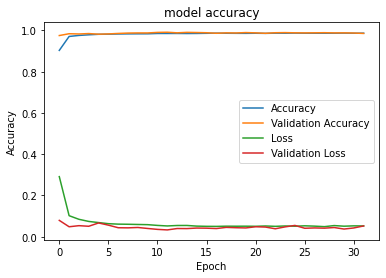

In [5]:
plt.plot(mnist_cnn.history['accuracy'])
plt.plot(mnist_cnn.history['val_accuracy'])
plt.plot(mnist_cnn.history['loss'])
plt.plot(mnist_cnn.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])
plt.show()

# **Test Evaluation and Prediction**

Using the test set, the trained model is evaluated by computing the loss and therefore, accuracy is calculated by the number of correct predictions.

**Note :** You can directly use the ```model``` object for prediction. For illustration purpose, I have shown how to load a pre-trained saved model from disk.

In [6]:
trained_model = load_model("mnist-cnn.h5")
test_eval = trained_model.evaluate(X_test, y_test, verbose=1)
print('Test loss : ',test_eval[0],'\nTest accuracy : ',test_eval[1])

y_pred = trained_model.predict(X_test)
y_pred = np.round(y_pred)

print("Target 1 : ",y_test[0],"\nPredicted 1 : ",y_pred[0])

157/157 [==============================] - 1s 5ms/step - loss: 0.0269 - accuracy: 0.9936
Test loss :  0.02692016027867794 
Test accuracy :  0.9936000108718872
Target 1 :  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.] 
Predicted 1 :  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## Determining the number of correct classifications

As all the labels have been converted into categorical data, hence we need to compare the Target and Predicted labels in a different manner. From the above cell's output, we can understand that, both the arrays has to be exactly identical in case of a correct classification. I have done that comparison by writing my own code.

The value in variable ```misflag``` becomes $1$ whenever it gets a mismatch of an index value in both the arrays. The outer ```for``` loop iterates over all the instances' Target as well as Predicted labels. The inner ```for``` loop scans the binary elements of each of the categorical Target/Predicted labels.

In [7]:
cclf=0
for i in range(num_test):
  misflag=0
  for j in range(num_labels):
    if y_test[i][j] != y_pred[i][j] :
      misflag=1
      break
  if misflag==0:
    cclf+=1
print("Number of correct classifications : ",cclf,"\nNumber of misclassifications : ",num_test-cclf,"\nFraction : ",cclf/num_test)

Number of correct classifications :  4986 
Number of misclassifications :  14 
Fraction :  0.9972


## Classification report

This report includes the **Precision**, **Recall** and **F1 score**. I have used ```Scikits-learn```'s inbuilt method to generate the values.

In [8]:
label_names=[f"Class {i}" for i in range(10)]
print(classification_report(y_test,y_pred,target_names=label_names))

              precision    recall  f1-score   support

     Class 0       1.00      0.99      1.00       520
     Class 1       1.00      0.98      0.99       564
     Class 2       1.00      1.00      1.00       502
     Class 3       1.00      0.99      1.00       510
     Class 4       1.00      0.99      1.00       482
     Class 5       1.00      0.99      0.99       436
     Class 6       0.98      1.00      0.99       496
     Class 7       0.99      0.99      0.99       516
     Class 8       0.99      0.99      0.99       485
     Class 9       1.00      0.99      0.99       489

   micro avg       0.99      0.99      0.99      5000
   macro avg       1.00      0.99      0.99      5000
weighted avg       1.00      0.99      0.99      5000
 samples avg       0.99      0.99      0.99      5000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
